In [60]:
%matplotlib inline
import numpy as np
import math
from skimage import io
from matplotlib import pylab as plt

In [61]:
def bresenham(x1, y1, x2, y2, img):
    x = x1
    y = y1
    sumOfLine = 0
    count = 0
    if x1 < x2:
        xi = 1
        dx = x2 - x1
    else:
        xi = -1
        dx = x1 - x2

    if y1 < y2:
        yi = 1
        dy = y2 - y1
    else:
        yi = -1
        dy = y1 - y1

    sumOfLine += img[x, y]
    count += 1
    if dx > dy:
        ai = (dy - dx) * 2
        bi = dy * 2
        d = bi - dx
        while x != x2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                x += xi
                d += bi
            sumOfLine += img[x, y]
            count += 1
    else:
        ai = (dx - dy) * 2
        bi = dx * 2
        d = bi - dy
        while y != y2:
            if d >= 0:
                x += xi
                y += yi
                d += ai
            else:
                y += yi
                d += bi
            sumOfLine += img[x, y]
            count += 1

    return sumOfLine/count

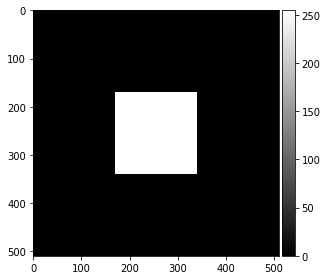

In [91]:
square_size = 510
square = np.zeros((square_size,square_size), dtype=np.float64)
square[int(square_size/3):int(2*square_size/3), int(square_size/3):int(2*square_size/3)]=255
io.imshow(square, cmap='gray')

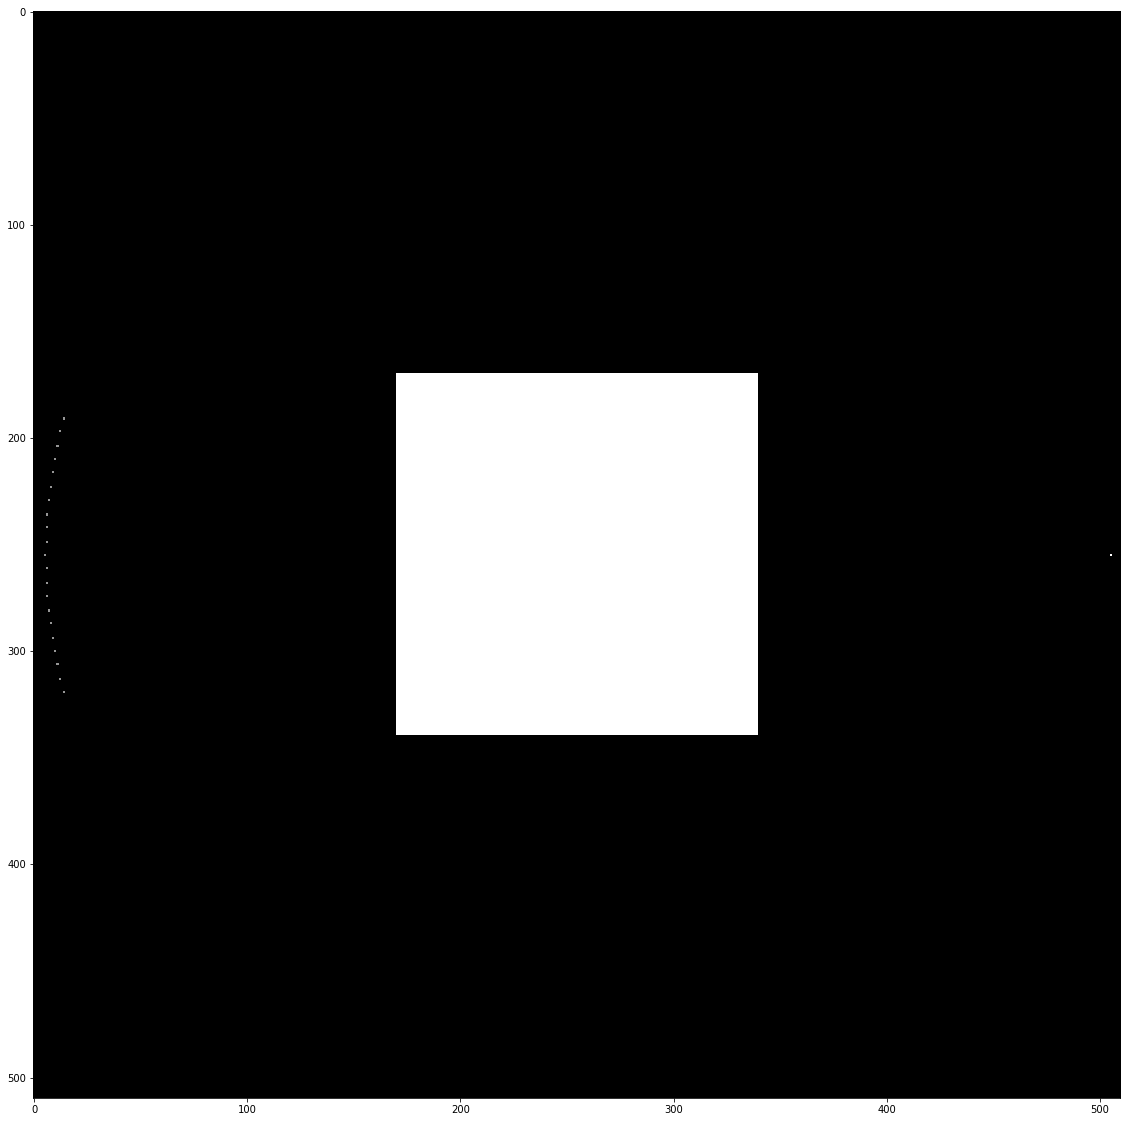

In [92]:
# Przyrost katów inc_angle emitera (położenie emitera), kąt z jakim wysyłane są fale (emiter_angle)
inc_angle, emiter_angle = 2, 15.0
beta = emiter_angle*2
centre = int(square_size/2)
detectors = 21
radius = centre-5

def coordToCart(angle, cx, cy, radius):
    x = int(math.cos(math.radians(angle)) * (radius)) + cx
    y = int(math.sin(math.radians(angle)) * (radius)) + cy
    return x,y

sinogram = np.zeros((int(360/inc_angle),detectors))

#petla - kazda pozycja emitera
for angle in range(0, 360, inc_angle):
    emiter_x, emiter_y = coordToCart(angle, centre, centre, radius)
    if(angle == 90):
        square[emiter_x, emiter_y] = 255
    #print(emiter_x, emiter_y)
    
    #petla - kazda pozycja detektora
    for a in range(detectors):
        alfa = angle + 180 - beta/2 + a*beta/(detectors-1)
        detx, dety = coordToCart(alfa, centre, centre, radius)
        if(angle ==90):
            square[detx, dety] = 150
        #print(detx, dety, alfa)
        #bresenham
        #suma = bresenham(emiter_x, emiter_y, detx, dety, square)
        #sinogram[int(angle/inc_angle),a] = suma
        
#print( sinogram)
#print(square[0,0])
fig, ax = plt.subplots(figsize=(40,20))
ax.imshow(square, cmap='gray')
#ax.imshow(sinogram, cmap='gray')